In [1]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
base_path = "iam-handwriting-word-database"
words_list = []

words = open(f"{base_path}/words_new.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [3]:
split_idx = int(0.7 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")
print(f"Total: {len(train_samples) + len(validation_samples) + len(test_samples)}")

Total training samples: 26813
Total validation samples: 5746
Total test samples: 5746
Total: 38305


In [4]:
base_image_path = os.path.join(base_path, "iam_words/words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [5]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  19
Vocab size:  76


['a', ',', 'industry', 'degree', 'part', 'are', 'parties', 'of', '400', '.']

In [6]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

print(char_to_num.get_vocabulary())

['[UNK]', '!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [8]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [9]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


In [10]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

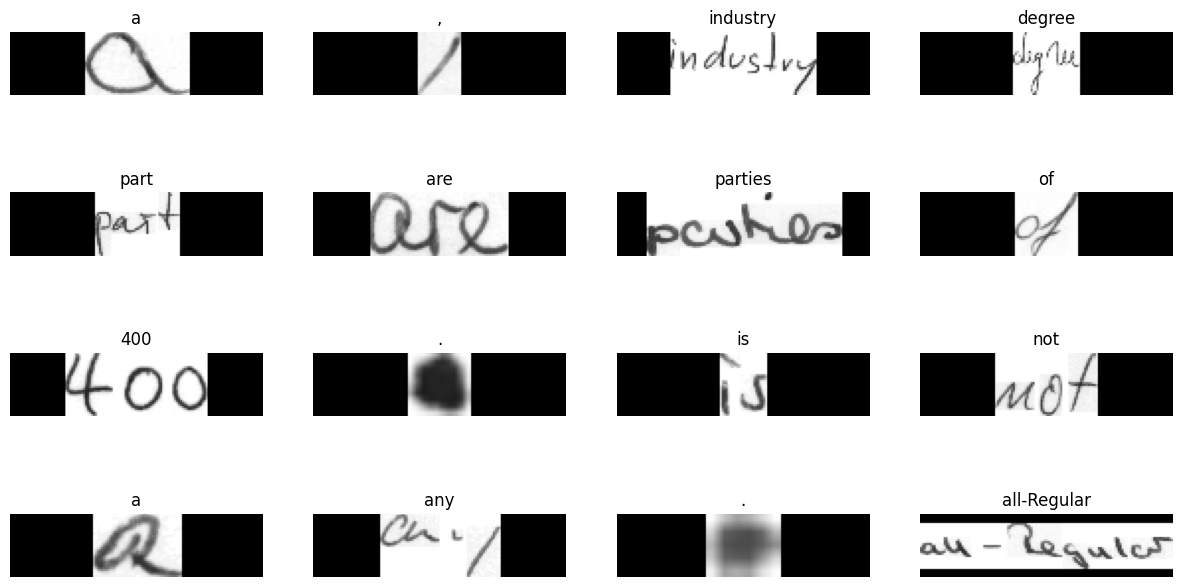

In [32]:
import cv2
import imutils

In [33]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [131]:
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image

def get_letter_bounding_boxes(img_path):
    # Read the image
    image = cv2.imread(img_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply threshold
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # Dilate the image
    dilated = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bounding_boxes = []
    for contour in contours:
        # Filter out small contours based on area
        if cv2.contourArea(contour) > 10:
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append((x, y, w, h))

            # Draw bounding box on the original image (optional)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Return the bounding boxes
    return bounding_boxes, image


def get_letter_bounding_boxes_tf(image_tensor):
    # Convert the image to grayscale
    gray = tf.image.rgb_to_grayscale(image_tensor)

    # Normalize to range [0, 1]
    gray = tf.image.convert_image_dtype(gray, tf.float32)

    # Invert colors to match the OpenCV approach
    gray = 1.0 - gray

    # Convert image back to uint8 for OpenCV operations
    gray_uint8 = tf.image.convert_image_dtype(gray, tf.uint8)

    # Apply threshold
    _, binary = cv2.threshold(gray_uint8.numpy(), 127, 255, cv2.THRESH_BINARY)

    # Dilate the image
    dilated = cv2.dilate(binary, None, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bounding_boxes = []
    for contour in contours:
        # Filter out small contours based on area
        if cv2.contourArea(contour) > 10:
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append((x, y, w, h))

            # Draw bounding box on the original image
            cv2.rectangle(image_tensor.numpy(), (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Return the bounding boxes and the image
    return bounding_boxes, image_tensor

import cv2
import numpy as np

def get_letter_bounding_boxes_np2(image):
    # Ensure the image is in grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply threshold
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # Dilate the image
    dilated = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bounding_boxes = []
    for contour in contours:
        # Filter out small contours based on area
        if cv2.contourArea(contour) > 10:
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append((x, y, w, h))

            # Draw bounding box on the original image
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Return the bounding boxes and the image
    return bounding_boxes, image

import cv2
import numpy as np

def get_letter_bounding_boxes_np(image):
    # Ensure the image is in grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply threshold
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # Dilate the image
    dilated = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bounding_boxes = []
    for contour in contours:
        # Filter out small contours based on area
        if cv2.contourArea(contour) > 10:
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append((x, y, w, h))

            # Draw bounding box on the grayscale image
            cv2.rectangle(gray, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Return the bounding boxes and the image
    return bounding_boxes, gray

def get_letter_bounding_boxes_np3(image):

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply threshold
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # Dilate the image
    dilated = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bounding_boxes = []
    for contour in contours:
        # Filter out small contours based on area
        if cv2.contourArea(contour) > 10:
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append((x, y, w, h))

            # Draw bounding box on the original image (optional)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Return the bounding boxes
    return bounding_boxes, image

def get_letter_bounding_boxes_number2(img_path, num_contours, fixed_height):
    # Read the image
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply threshold
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # Dilate the image
    dilated = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area in descending order
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Check if the height is equal to the fixed height
        if h == fixed_height:
            bounding_boxes.append((x, y, w, h))

            # Draw bounding box on the original image (optional)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Stop when we have found the given number of bounding boxes
            if len(bounding_boxes) == num_contours:
                break

    # Return the bounding boxes
    return bounding_boxes, image

def get_letter_bounding_boxes_number3(img_path, num_contours, fixed_height):
    # Read the image
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply threshold
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # Dilate the image
    dilated = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area in descending order
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, w, fixed_height))

        # Draw bounding box with fixed height on the original image
        cv2.rectangle(image, (x, y), (x + w, y + fixed_height), (0, 255, 0), 2)

        # Stop when we have found the given number of bounding boxes
        if len(bounding_boxes) == num_contours:
            break

    # Return the bounding boxes
    return bounding_boxes, image

def get_letter_bounding_boxes_number4(img_path, num_contours, fixed_height):
    # Read the image
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    bounding_boxes = []
    threshold = 127
    direction = -1
    while 0 < threshold < 256:
        # Apply threshold
        _, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)

        # Dilate the image
        dilated = cv2.dilate(thresh, None, iterations=2)

        # Find contours
        contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Sort contours by area in descending order
        contours = sorted(contours, key=cv2.contourArea, reverse=True)

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append((x, y, w, fixed_height))

            # Draw bounding box with fixed height on the original image
            cv2.rectangle(image, (x, y), (x + w, y + fixed_height), (0, 255, 0), 2)

            # Stop when we have found the given number of bounding boxes
            if len(bounding_boxes) == num_contours:
                return bounding_boxes, image

        # Update threshold
        threshold += direction
        if threshold == 0 or threshold == 255:
            direction *= -1

    # Return the bounding boxes
    return bounding_boxes, image

def get_letter_bounding_boxes_number5(img_path, num_contours, fixed_height):
    # Read the image
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    bounding_boxes = []
    initial_threshold = 127
    for i in range(256):  # Maximum number of iterations
        # Calculate threshold
        threshold = initial_threshold + ((i // 2 + 1) * (-1) ** i)
        
        # Check if threshold is within valid range
        if 0 < threshold < 256:
            # Apply threshold
            _, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)

            # Dilate the image
            dilated = cv2.dilate(thresh, None, iterations=1)

            # Find contours
            contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Sort contours by area in descending order
            contours = sorted(contours, key=cv2.contourArea, reverse=True)

            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                bounding_boxes.append((x, y, w, fixed_height))

                # Generate a random color
                color = tuple(np.random.randint(0, 256, 3).tolist())

                # Draw bounding box with fixed height on the original image
                cv2.rectangle(image, (x, y), (x + w, y + fixed_height), color, 2)
                print(len(contours))
                # Stop when we have found the given number of bounding boxes
                if len(bounding_boxes) == num_contours:
                    return bounding_boxes, image

    # Return the bounding boxes
    return bounding_boxes, image

import numpy as np

def get_letter_bounding_boxes_number(img_path, num_contours, fixed_height):
    # Read the image
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    bounding_boxes = []
    initial_threshold = 127
    fixed_width = None
    for i in range(256):  # Maximum number of iterations
        # Calculate threshold
        threshold = initial_threshold + ((i // 2 + 1) * (-1) ** i)

        # Check if threshold is within valid range
        if 0 < threshold < 256:
            
            # Apply threshold
            _, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)

            # Dilate the image
            dilated = cv2.dilate(thresh, None, iterations=1)

            # Find contours
            contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Sort contours by area in descending order
            contours = sorted(contours, key=cv2.contourArea, reverse=True)

            if contours:
                x, y, w, h = cv2.boundingRect(contours[0])

                # Set the fixed width based on the first contour
                if fixed_width is None:
                    fixed_width = w

                color = tuple(np.random.randint(0, 256, 3).tolist())
                cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
                bounding_boxes.append((x, y, w, h))
                
                for i in range(num_contours):
                    # Generate a random color
                    color = tuple(np.random.randint(0, 256, 3).tolist())

                    # Draw bounding box with fixed height and width on the original image
                    cv2.rectangle(image, (x + i * fixed_width, y), (x + (i + 1) * fixed_width, y + fixed_height), color, 2)

                    bounding_boxes.append((x + i * fixed_width, y, fixed_width, fixed_height))

                return bounding_boxes, image

    # Return the bounding boxes
    return bounding_boxes, image


def draw_bounding_boxes(img_path, num_boxes, box_height2):
    # Read the image
    image = cv2.imread(img_path)

    bounding_boxes = []
    start_x = 0  # Starting x coordinate for the first box
    start_y = 10  # Starting y coordinate for the boxes

    total_width = image.shape[1]  # Get the width of the image
    box_width = total_width // num_boxes  # Calculate the width of each box
    
    box_height = image.shape[1]
    

    for i in range(num_boxes):
        # Generate a random color
        color = tuple(np.random.randint(0, 256, 3).tolist())

        # Draw bounding box with fixed height and width on the original image
        cv2.rectangle(image, (start_x + i * box_width, start_y), (start_x + (i + 1) * box_width, start_y + box_height), color, 2)

        bounding_boxes.append((start_x + i * box_width, start_y, box_width, box_height))

    # Return the bounding boxes and the image
    return bounding_boxes, image

def draw_bounding_boxes_on_np(image_array, num_boxes, box_height):
    bounding_boxes = []
    start_x = 0  # Starting x coordinate for the first box
    start_y = 10  # Starting y coordinate for the boxes

    total_width = image_array.shape[1]  # Get the width of the image
    box_width = total_width // num_boxes  # Calculate the width of each box

    for i in range(num_boxes):
        # Generate a random color
        color = tuple(np.random.randint(0, 256, 3).tolist())

        # Draw bounding box with fixed height and width on the original image
        cv2.rectangle(image_array, (start_x + i * box_width, start_y), (start_x + (i + 1) * box_width, start_y + box_height), color, 2)

        bounding_boxes.append((start_x + i * box_width, start_y, box_width, box_height))

    # Return the bounding boxes and the image
    return bounding_boxes, image_array

In [38]:
def get_word(letter):
    word = "".join(letter)
    return word

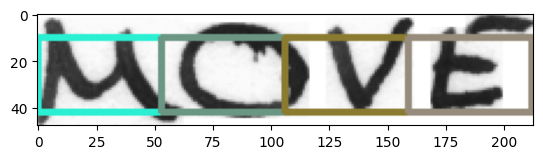

In [130]:
#letter,image = get_letter_bounding_boxes("handwriting-recognition/train_v2/train/TRAIN_00003.jpg")
letter,image = draw_bounding_boxes("iam-handwriting-word-database/iam_words/words/a01/a01-000u/a01-000u-00-01.png", 4, 32)

#word = get_word(letter)
#print(word)
plt.imshow(image)

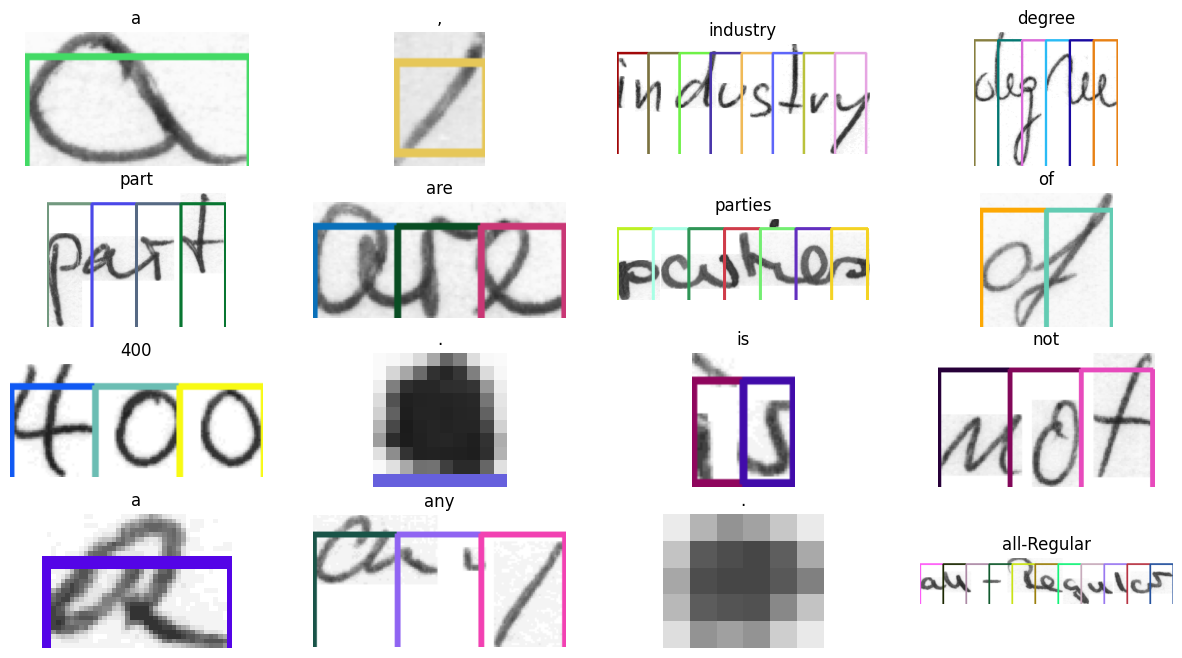

In [132]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        #letter, img = get_letter_bounding_boxes_number(img, len(label), img.shape[0])
        
        #letter, img = draw_bounding_boxes(train_img_paths[i], len(label), img.shape[0]) # img.shape[0] = 32 height is fixed
        #letter, img = draw_bounding_boxes(img, len(label), img.shape[0])
        
        letter, img = get_letter_bounding_boxes(train_img_paths[i])
        
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")